In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import * 
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

import pandas as pd
import numpy as np
import os

fastai.version.__version__

'1.0.39'

In [3]:
# make sure CUDA is available and enabled
print('CUDA enabled:',torch.cuda.is_available()) 
print('CUDNN enabled:', torch.backends.cudnn.enabled)

CUDA enabled: True
CUDNN enabled: True


In [4]:
def recreate_directory(directory):
    !rm -R {directory} 2>nul
    !mkdir {directory}

# Dataset preprocessing

In [5]:
current_dir = os.getcwd()
input_path =f'{current_dir}/data'
train_dir = f"{input_path}/train"
train_labels = f"{input_path}/train.csv"
test_dir = f"{input_path}/test"
model_dir = f'{current_dir}/models'

## Train model

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0
arch = models.resnet50

In [7]:
df = pd.read_csv(train_labels)
df = df.sample(frac=0.25)
df = df.reset_index()

print(df.shape)
print(df.head())

(6340, 3)
   index          Image         Id
0  20443  cddfcdbc6.jpg  w_0717f05
1   3775  26bb255b5.jpg  new_whale
2  13546  8865153d7.jpg  w_1ca9ab1
3  15593  9d2c4d9c4.jpg  w_e2372d6
4   7317  4a3047424.jpg  w_150a6f5


In [8]:
grouped_df = df.groupby('Id')
grouped_counted = grouped_df.count().sort_values(by=['Image'], ascending=False)
grouped_counted = grouped_counted[(grouped_counted['Image']>5) & (grouped_counted['Image']<1000)]
print(len(grouped_counted))
print(grouped_counted.sum().Image, 'of', len(df))
print(grouped_counted.head())

70
589 of 6340
           index  Image
Id                     
w_0369a5c     18     18
w_23a388d     18     18
w_2b069ba     17     17
w_700ebb4     16     16
w_9c506f6     15     15


In [9]:
valid_pct = 0.2

valid_filenames = pd.DataFrame(columns=df.columns)

for name, group in enumerate(grouped_df):
    sub_df = group[1]
    sample = sub_df.sample(frac=valid_pct)
    valid_filenames = valid_filenames.append(sample, ignore_index=True)

In [10]:
valid_filenames.drop(labels=['index'], axis=1, inplace=True, errors='ignore')

print(valid_filenames.shape)
print(valid_filenames.head())

(860, 2)
           Image         Id
0  092a3bfa7.jpg  new_whale
1  76c2f59a1.jpg  new_whale
2  0ddc00629.jpg  new_whale
3  e2244d61c.jpg  new_whale
4  ce8c89602.jpg  new_whale


In [11]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [12]:
valid_files = ItemList.from_df(df=valid_filenames, path=train_dir, cols=['Image'])

In [13]:
test_files = ImageItemList.from_folder(test_dir)

In [14]:
# TODO label from df?
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
#         .no_split()
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

In [15]:
#data.show_batch(rows=3, fig_size=(SZ, SZ))

# Learning rate

In [ ]:
# data_lr = (
#     ImageItemList
#         .from_df(df, train_dir, cols=['Image'])
# #         .no_split()
#         .split_by_files(valid_files)
#         .label_from_func(lambda path: fn2label[path2fn(path)])
#         .add_test(test_files)
#         .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
#         .normalize(imagenet_stats)
# )

In [16]:
# learn = create_cnn(data_lr, arch, metrics=accuracy, model_dir=model_dir)

In [20]:
# learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


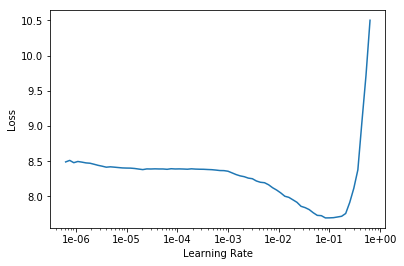

In [21]:
# learn.recorder.plot()

# Precompute

In [22]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir=model_dir, callback_fns=ShowGraph)

In [ ]:
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
#         .no_split()
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(get_transforms(do_flip=False), size=64, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

epoch,train_loss,valid_loss,accuracy
1,6.630241,3.555329,0.561628
2,5.966783,3.390838,0.568605
3,5.460571,3.182754,0.561628
4,4.810892,2.897452,0.576744
5,4.054265,2.883345,0.576744


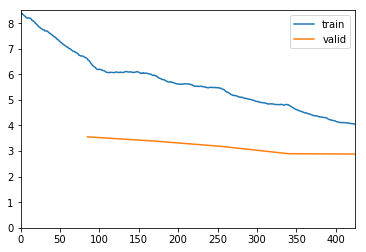

In [23]:
learn.fit_one_cycle(5, wd=1e-4, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,3.557450,2.929773,0.560465
2,3.238094,2.747407,0.587209
3,2.844496,2.691837,0.595349
4,2.537881,2.673568,0.589535
5,2.372685,2.689216,0.584884


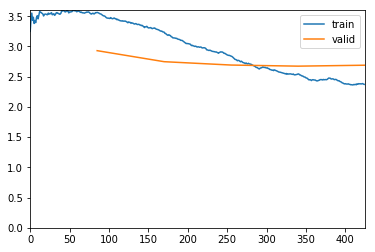

In [30]:
learn.unfreeze()
lr_rate = 1e-3
learn.fit_one_cycle(5, wd=1e-4, max_lr=[lr_rate/100, lr_rate/10, lr_rate])

In [ ]:
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
#         .no_split()
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(get_transforms(do_flip=False), size=128, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

In [ ]:
learn.freeze()
learn.fit_one_cycle(5, wd=1e-4, max_lr=1e-2)

In [ ]:
learn.unfreeze()
lr_rate = 1e-3
learn.fit_one_cycle(5, wd=1e-4, max_lr=[lr_rate/100, lr_rate/10, lr_rate])

In [ ]:
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
#         .no_split()
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(get_transforms(do_flip=False), size=256, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

In [ ]:
learn.freeze()
learn.fit_one_cycle(5, wd=1e-4, max_lr=1e-2)

In [ ]:
learn.unfreeze()
lr_rate = 1e-3
learn.fit_one_cycle(5, wd=1e-4, max_lr=[lr_rate/100, lr_rate/10, lr_rate])

# Prediction & Summition - TODO

In [23]:
log_preds,y = learn.TTA(ds_type=DatasetType.Test)

In [24]:
def top_preds(preds, classes):
    top = np.argsort(preds.numpy())[:, ::-1][:, :5]
    labels = []
    for i in range(top.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top[i]]))
    return labels

def create_submission(preds, data):
    classes = data.classes
    sub_df = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub_df['Id'] = top_preds(preds, classes)
    return sub_df

In [25]:
submittion_df = create_submission(log_preds, learn.data)

In [26]:
submittion_file = 'submission-4.csv'
submittion_df.to_csv(submittion_file, index=False)

In [27]:
print(submittion_df.head())
print(submittion_df.shape)

           Image                                                 Id
0  a82ba2f76.jpg  new_whale w_89f6097 w_6aab519 w_94f41dc w_5a2634c
1  ab62db5a5.jpg  new_whale w_88445b2 w_5a2634c w_7488eec w_fdcaaa8
2  6219200df.jpg  new_whale w_7e2eb3d w_1d0830e w_9c506f6 w_aabdf8c
3  0f3c1f2ca.jpg  new_whale w_9b5109b w_d405854 w_cd4cb49 w_4bf625b
4  7d139670e.jpg  new_whale w_f602022 w_343f088 w_b950c88 w_0887d9b
(7960, 2)


In [28]:
!kaggle competitions submit -c humpback-whale-identification -f {submittion_file} -m "learning on different img sizes"

100%|█████████████████████████████████████████| 498k/498k [00:02<00:00, 180kB/s]
Successfully submitted to Humpback Whale Identification